In [1]:
## Подключаем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import pandas as pd
import yfinance as yf
import matplotlib
from pandas_datareader import data as pdr
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
from pandas_datareader import data as web
import datetime
from nsepy import get_history
from nsepython import *
import logging
urllib3_logger = logging.getLogger('urllib3') # Обработчик сообщений, чтобы они не выводились при сборе данных о тикерах
urllib3_logger.setLevel(logging.CRITICAL)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import monthly_returns_heatmap as mrh
from tabulate import tabulate
import cvxpy as cp
import math
import seaborn as sns
# Need to import the matplotlib_converters from pandas,
# whenever you try to plot the columns of a dataframe using a for loop

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [28]:
list_of_tickers = ["VTBR.ME", "YNDX.ME", "AGRO.ME", "NVTK.ME", "PLZL.ME"]
index = ['IMOEX.ME']
start = datetime.datetime(2018,1,1)
end = datetime.datetime.today().date() # сегодняшняя дата, чтобы не менять вручную.
# Получаем данные из Yahoo. Именно этот способ позволяет получить данные с тикерами в столбцах.
f = pdr.DataReader(list_of_tickers, 'yahoo', start, end)
index_df = pdr.DataReader(index, 'yahoo', start, end)

In [29]:
data_pc = f.pct_change()
data_pc = pd.DataFrame(data_pc["Close"])
index_pc = index_df.pct_change()
index_pc = pd.DataFrame(index_pc["Close"])
data_pc.head(5)

Symbols,VTBR.ME,YNDX.ME,AGRO.ME,NVTK.ME,PLZL.ME
Date,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.011111,0.017751,-0.008772,0.003165,0.002687
2018-01-05,0.002997,-0.017947,-0.004425,0.005306,-0.002010
2018-01-09,0.011952,0.010553,0.007111,-0.007989,0.019467
2018-01-10,-0.005709,0.004585,0.006178,-0.014380,-0.031826


In [30]:
# Drop the first row containing the null values
data_pc.dropna(inplace=True)

# Calculate the cumulative percentage returns of each stock
data_cumulative_returns = (data_pc+1).cumprod()*100
data_cumulative_returns.head()

Symbols,VTBR.ME,YNDX.ME,AGRO.ME,NVTK.ME,PLZL.ME
Date,,,,,
2018-01-04,101.111115,101.775148,99.122807,100.316503,100.268697
2018-01-05,101.414143,99.948546,98.684211,100.848802,100.067174
2018-01-09,102.626262,101.003344,99.385965,100.043166,102.015226
2018-01-10,102.040405,101.466427,100.000000,98.604524,98.768473
2018-01-11,102.020206,101.106252,99.736842,98.892253,97.559337


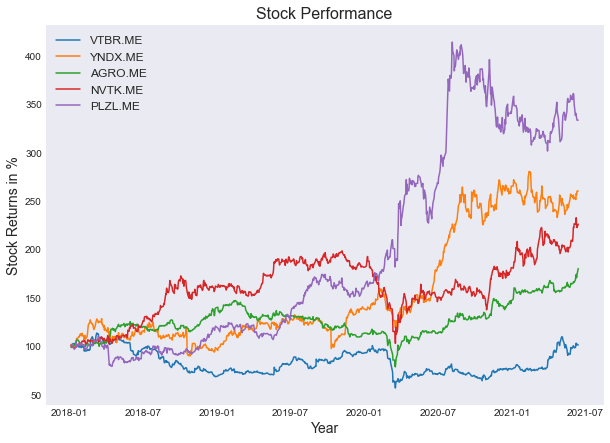

In [31]:
# Plot the returns of both the stocks
plt.figure(figsize=(10, 7))
for column in data_pc.columns.values:
    plt.plot(data_pc.index, data_cumulative_returns[column], label=column)

plt.legend(loc='best', fontsize=12)
plt.title('Stock Performance', fontsize=16)
plt.ylabel('Stock Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

## Create the Kelly Criterion

In [32]:
# Save the number of stocks in a variable
no_of_stocks = data_pc.shape[1]
no_of_stocks

5

In [33]:
weights = cp.Variable(no_of_stocks)
weights.shape

(5,)

In [34]:
# Save the portfolio returns in a variable
portfolio_returns = (np.array(data_pc) @ weights)
portfolio_returns

Expression(AFFINE, UNKNOWN, (863,))

In [35]:
(np.array(data_pc) @ weights)

Expression(AFFINE, UNKNOWN, (863,))

In [36]:
final_portfolio_value = cp.sum(cp.log(1+portfolio_returns))
final_portfolio_value

Expression(CONCAVE, UNKNOWN, ())

In [37]:
objective = cp.Maximize(final_portfolio_value)
objective

Maximize(Expression(CONCAVE, UNKNOWN, ()))

In [38]:
constraints = [0.0 <= weights, cp.sum(weights) == 1]
constraints

[Inequality(Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))]

In [39]:
problem = cp.Problem(objective, constraints)
problem

Problem(Maximize(Expression(CONCAVE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))])

In [40]:
# The optimal objective value is returned by `prob.solve()`.
problem.solve()

# The optimal value for w is stored in `w.value`.
print(weights.value)

[7.75177197e-14 1.34051270e-01 4.42307999e-13 1.93732221e-12
 8.65948730e-01]


## Create Kelly portfolio

In [41]:
kelly_portfolio_returns = ((data_pc)*(weights.value)).sum(axis=1)
kelly_portfolio_returns

Date
2018-01-04    0.004706
2018-01-05   -0.004146
2018-01-09    0.018273
2018-01-10   -0.026945
2018-01-11   -0.011077
                ...   
2021-06-08    0.004457
2021-06-09   -0.002914
2021-06-10   -0.007804
2021-06-11   -0.002787
2021-06-14    0.000074
Length: 863, dtype: float64

In [42]:
kelly_portfolio_value = (1+(kelly_portfolio_returns)).cumprod()
kelly_portfolio_value.head()

Date
2018-01-04    1.004706
2018-01-05    1.000541
2018-01-09    1.018823
2018-01-10    0.991371
2018-01-11    0.980389
dtype: float64

In [43]:
kelly_annualized_returns = (
    (kelly_portfolio_value[-1])**(252/len(data_pc)))-1

# Print the annualized returns of the Kelly portfolio
kelly_annualized_returns

0.42405542982986155

In [44]:
equal_weight_portfolio = (1+((data_pc).mean(axis=1))).cumprod()
equal_weight_portfolio.head()

Date
2018-01-04    1.005189
2018-01-05    1.001956
2018-01-09    1.010191
2018-01-10    1.001877
2018-01-11    0.998730
dtype: float64

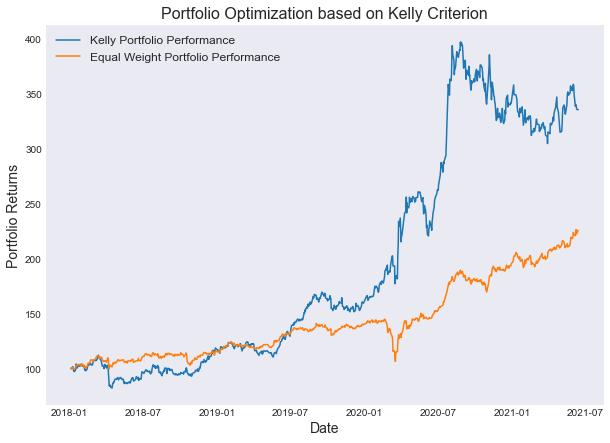

In [45]:
# Plot the percentage returns of Kelly and Equal Weight portfolios
plt.figure(figsize=(10, 7))
plt.plot(kelly_portfolio_value*100, label='Kelly Portfolio Performance')
plt.plot(equal_weight_portfolio*100,
         label='Equal Weight Portfolio Performance')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Returns', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.title('Portfolio Optimization based on Kelly Criterion', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [48]:
weights.value.round(2)

array([0.  , 0.13, 0.  , 0.  , 0.87])

In [ ]:
["VTBR.ME", "YNDX.ME", "AGRO.ME", "NVTK.ME", "PLZL.ME"]